#  Bloque 1 

In [2]:
# ==========================================
# BLOQUE 1: SETUP ENTORNO (SILENCIOSO & ROBUSTO)
# ==========================================
# @title 1. Configuración Inicial y Corrección de Librerías
import os
import sys
import subprocess
import warnings
import importlib

# Suprimir advertencias de Python
warnings.filterwarnings("ignore")

def setup_environment():
    print("🏗️ Configurando entorno de trabajo...")
    
    def robust_install(package_list):
        # Instalación silenciosa: capturamos stdout y stderr para no ensuciar la consola
        # con conflictos de dependencias irrelevantes (bigframes, tensorflow, etc.)
        try:
            print(f"   ⚙️ Instalando/Verificando: {' '.join(package_list)} ...")
            subprocess.run(
                [sys.executable, "-m", "pip", "install", "-q"] + package_list,
                check=True,  # Verificamos si pip falla catastróficamente
                capture_output=True, # Ocultamos el texto rojo de conflictos
                text=True
            )
            return True
        except subprocess.CalledProcessError as e:
            # Si falla, revisamos si es un error crítico o solo advertencias
            # Para este caso, asumimos que si SAM 2 carga después, todo está bien.
            return False

    # 1. GESTIÓN DE NUMPY (CRÍTICO: MANTENER < 2.0)
    try:
        import numpy
        # Si detectamos Numpy 2.x, forzamos downgrade inmediato
        if numpy.__version__.startswith("2"):
            print("   ⚠️ Numpy 2.x detectado (Incompatible). Realizando downgrade a 1.x...")
            robust_install(["numpy<2"])
            print("   🔄 Numpy corregido. Si hay errores posteriores, REINICIA EL KERNEL.")
    except ImportError:
        robust_install(["numpy<2"])

    # 2. INSTALACIÓN DE SAM 2
    try:
        import sam2
        print("   ✅ SAM 2 listo.")
    except ImportError:
        robust_install(["git+https://github.com/facebookresearch/segment-anything-2.git"])

    # 3. INSTALACIÓN GEOESPACIAL
    try:
        import geopandas
        import rasterio
        print("   ✅ Geoespacial listo.")
    except ImportError:
        robust_install(["shapely", "geopandas", "rasterio", "opencv-python-headless"])
    
    print("✅ Entorno configurado correctamente.")

setup_environment()

# --- IMPORTACIONES ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import requests
from shapely.geometry import Polygon
import geopandas as gpd
import torch

# --- CONFIGURACIÓN HARDWARE ---
if torch.cuda.is_available():
    DEVICE = "cuda"
    gpu_name = torch.cuda.get_device_name(0)
    print(f"🚀 GPU Activa: {gpu_name}")
    
    # Optimización de precisión según arquitectura
    if "T4" in gpu_name or "A100" in gpu_name:
        torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
        # Activar TensorCores para matrices
        if torch.cuda.get_device_properties(0).major >= 8:
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
else:
    DEVICE = "cpu"
    print("⚠️ ADVERTENCIA: Estás usando CPU. Activa la GPU (T4/P100) para velocidad real.")

# --- DIRECTORIOS ---
try:
    WORK_DIR = "/kaggle/working" if os.path.exists("/kaggle/working") else os.getcwd()
except:
    WORK_DIR = "."
    
OUTPUT_DIR = os.path.join(WORK_DIR, "output_tiles")
os.makedirs(OUTPUT_DIR, exist_ok=True)

🏗️ Configurando entorno de trabajo...
   ✅ SAM 2 listo.
   ✅ Geoespacial listo.
✅ Entorno configurado correctamente.
🚀 GPU Activa: Tesla T4


#  Bloque 2

In [3]:

# ==========================================
# BLOQUE 2: CARGA DE IMAGEN
# ==========================================
# @title 2. Carga de Mapa Geológico
original_image_global = None
processed_image_global = None

def image_loader_ui():
    style = {'description_width': 'initial'}
    
    # UI Elements
    lbl_title = widgets.HTML("<h3>📍 Carga de Imagen</h3>")
    source_w = widgets.Dropdown(options=['GitHub URL', 'Subir Archivo'], value='GitHub URL', description='Fuente:', style=style)
    url_w = widgets.Text(value="https://raw.githubusercontent.com/DalemberV/Geodigit/main/Digitalizacion_Automatica/Mapas%20geol%C3%B3gicos/gironim.png", placeholder='URL...', layout=widgets.Layout(width='60%'))
    upload_w = widgets.FileUpload(accept='image/*', multiple=False)
    btn_load = widgets.Button(description="Cargar", button_style='primary')
    out = widgets.Output()

    def on_load(b):
        global original_image_global
        with out:
            clear_output()
            try:
                if source_w.value == 'GitHub URL':
                    print(f"Descargando: {url_w.value} ...")
                    resp = requests.get(url_w.value, stream=True).raw
                    original_image_global = Image.open(resp).convert("RGB")
                else:
                    if not upload_w.value: return print("❌ Selecciona un archivo.")
                    f_info = next(iter(upload_w.value.values())) # Kaggle file upload struct
                    original_image_global = Image.open(io.BytesIO(f_info['content'])).convert("RGB")
                
                print(f"✅ Imagen cargada: {original_image_global.size}")
                # Mostrar thumbnail
                thumb = original_image_global.copy()
                thumb.thumbnail((400, 400))
                display(thumb)
                
            except Exception as e:
                print(f"❌ Error: {e}")

    btn_load.on_click(on_load)
    display(widgets.VBox([lbl_title, widgets.HBox([source_w, url_w, upload_w, btn_load]), out]))

image_loader_ui()


# Bloque 3

In [4]:
# ==========================================
# BLOQUE 3: PREPROCESAMIENTO
# ==========================================
# @title 3. Ajuste Visual (Preprocesamiento)
def preprocessing_ui():
    style = {'description_width': 'initial'}
    lbl_title = widgets.HTML("<h3>🎨 Ajuste de Imagen (Brillo/Contraste)</h3>")
    
    b_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='Brillo')
    c_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='Contraste')
    s_slider = widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Nitidez')
    btn_apply = widgets.Button(description="Confirmar y Guardar", button_style='success')
    out_prev = widgets.Output()

    def update_view(change=None):
        if original_image_global is None: return
        with out_prev:
            clear_output(wait=True)
            img = original_image_global.copy()
            img = ImageEnhance.Brightness(img).enhance(b_slider.value)
            img = ImageEnhance.Contrast(img).enhance(c_slider.value)
            img = ImageEnhance.Sharpness(img).enhance(s_slider.value)
            
            # Preview rápido
            w, h = img.size
            ratio = 500 / w
            plt.figure(figsize=(8, 4))
            plt.imshow(img.resize((500, int(h*ratio))))
            plt.axis('off')
            plt.title("Preview")
            plt.show()

    def apply_filters(b):
        global processed_image_global
        if original_image_global is None: return
        img = original_image_global.copy()
        img = ImageEnhance.Brightness(img).enhance(b_slider.value)
        img = ImageEnhance.Contrast(img).enhance(c_slider.value)
        processed_image_global = ImageEnhance.Sharpness(img).enhance(s_slider.value)
        print("✅ Imagen preprocesada lista para segmentar.")

    b_slider.observe(update_view, names='value')
    c_slider.observe(update_view, names='value')
    s_slider.observe(update_view, names='value')
    btn_apply.on_click(apply_filters)

    display(widgets.VBox([lbl_title, widgets.HBox([b_slider, c_slider, s_slider]), out_prev, btn_apply]))

preprocessing_ui()

# Bloque 4

In [5]:
# ==========================================
# BLOQUE 4: CARGA MODELO SAM 2
# ==========================================
# @title 4. Inicialización del Modelo
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

if not os.path.exists("sam2_hiera_large.pt"):
    print("⬇️ Bajando pesos SAM 2 Large...")
    os.system("wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt")

print("⚙️ Cargando Modelo a GPU...")
torch.set_grad_enabled(False)
sam2_model = build_sam2("sam2_hiera_l.yaml", "sam2_hiera_large.pt", device=DEVICE, apply_postprocessing=False)
print("✅ Modelo cargado en memoria (Weights loaded).")

⬇️ Bajando pesos SAM 2 Large...
⚙️ Cargando Modelo a GPU...
✅ Modelo cargado en memoria (Weights loaded).


# Bloque 5

In [7]:
# ==========================================
# BLOQUE 5: CONSOLA DINÁMICA DE SEGMENTACIÓN
# ==========================================
# @title 5. Explorador Dinámico (Tiempo Real + Side-by-Side + Cleaning)

class DynamicTileExplorer:
    def __init__(self, image, model):
        if image is None:
            print("❌ ERROR: Carga la imagen primero (Bloques 2 y 3).")
            return
            
        self.image = np.array(image)
        self.model = model
        self.H, self.W = self.image.shape[:2]
        self.tile_size = 1024
        self.tiles = self._generate_tiles()
        self.current_idx = 0
        self.current_masks = []
        self.gap_polygons = []
        
        # Semáforo para control de concurrencia
        self.is_processing = False
        
        # --- UI WIDGETS ---
        self.out_display = widgets.Output()
        self.out_status = widgets.Output()
        
        # Navegación
        self.btn_prev = widgets.Button(description="< Ant.", icon='arrow-left', layout=widgets.Layout(width='100px'))
        self.btn_next = widgets.Button(description="Sig. >", icon='arrow-right', layout=widgets.Layout(width='100px'))
        self.lbl_idx = widgets.Label(value=f"Tile: 1 / {len(self.tiles)}")
        
        # Parámetros SAM 2
        style = {'description_width': 'initial'}
        self.sl_points = widgets.IntSlider(value=64, min=32, max=128, step=16, description='Puntos (Densidad)', continuous_update=True, style=style)
        self.sl_iou = widgets.FloatSlider(value=0.70, min=0.1, max=0.99, step=0.05, description='Confianza (IOU)', continuous_update=True, style=style)
        self.sl_stability = widgets.FloatSlider(value=0.85, min=0.5, max=0.99, step=0.05, description='Estabilidad', continuous_update=True, style=style)
        self.sl_min_area = widgets.IntSlider(value=1000, min=100, max=10000, step=100, description='Área Mínima', continuous_update=True, style=style)
        
        # Filtros y Herramientas
        self.chk_bw_filter = widgets.Checkbox(value=True, description='Ignorar Fondo (B/N)')
        self.chk_solidify = widgets.Checkbox(value=True, description='Rellenar Agujeros (Solidificar)') # NUEVO
        self.chk_merge_overlap = widgets.Checkbox(value=True, description='Fusionar Overlap')
        self.sl_overlap_thresh = widgets.FloatSlider(value=0.80, min=0.1, max=1.0, step=0.05, description='Umbral Fusion %', continuous_update=True, style=style)
        self.chk_fill_gaps = widgets.Checkbox(value=True, description='Rellenar Huecos (Gap Fill)')
        self.chk_contours = widgets.Checkbox(value=True, description='Delinear Contornos')
        
        self.btn_save = widgets.Button(description="💾 Guardar Tile", button_style='success', icon='save')
        
        # --- EVENTOS ---
        self.btn_prev.on_click(self.prev_tile)
        self.btn_next.on_click(self.next_tile)
        self.btn_save.on_click(self.save_tile)
        
        # Observers
        self.sl_points.observe(self.on_param_change, names='value')
        self.sl_iou.observe(self.on_param_change, names='value')
        self.sl_stability.observe(self.on_param_change, names='value')
        self.sl_min_area.observe(self.on_param_change, names='value')
        
        # Visual Observers
        self.chk_fill_gaps.observe(self.refresh_visuals, names='value')
        self.chk_bw_filter.observe(self.refresh_visuals, names='value')
        self.chk_contours.observe(self.refresh_visuals, names='value')
        self.chk_merge_overlap.observe(self.refresh_visuals, names='value')
        self.sl_overlap_thresh.observe(self.refresh_visuals, names='value')
        self.chk_solidify.observe(self.refresh_visuals, names='value')

        self.render_ui()
        self.run_inference()

    def _generate_tiles(self):
        coords = []
        stride = int(self.tile_size * 0.9)
        if self.H < self.tile_size or self.W < self.tile_size:
            return [(0, 0, self.W, self.H)]
        for y in range(0, self.H, stride):
            for x in range(0, self.W, stride):
                x_end = min(x + self.tile_size, self.W)
                y_end = min(y + self.tile_size, self.H)
                x_start = max(0, x_end - self.tile_size)
                y_start = max(0, y_end - self.tile_size)
                coords.append((x_start, y_start, x_end, y_end))
        return coords

    def get_current_tile_img(self):
        x1, y1, x2, y2 = self.tiles[self.current_idx]
        return self.image[y1:y2, x1:x2]

    def prev_tile(self, b):
        if self.current_idx > 0:
            self.current_idx -= 1
            self.update_nav()
            self.run_inference()

    def next_tile(self, b):
        if self.current_idx < len(self.tiles) - 1:
            self.current_idx += 1
            self.update_nav()
            self.run_inference()

    def update_nav(self):
        self.lbl_idx.value = f"Tile: {self.current_idx + 1} / {len(self.tiles)}"

    def on_param_change(self, change):
        if not self.is_processing:
            self.run_inference()

    def solidify_masks(self, masks):
        """Rellena los agujeros internos de cada máscara para hacerlos sólidos."""
        if not self.chk_solidify.value: return masks
        
        solid_masks = []
        for m in masks:
            # Aseguramos que la fuente sea uint8 y contigua
            seg = m['segmentation'].astype(np.uint8)
            seg = np.ascontiguousarray(seg)
            
            # Encontrar contornos
            cnts, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # CORRECCIÓN: Crear máscara explícitamente contigua usando np.zeros en lugar de zeros_like
            # Esto garantiza que el layout de memoria sea compatible con OpenCV (C-style)
            new_mask = np.zeros(seg.shape, dtype=np.uint8)
            
            # Dibujar contornos externos RELLENOS
            cv2.drawContours(new_mask, cnts, -1, 1, thickness=cv2.FILLED)
            
            # Actualizar datos
            m_copy = m.copy()
            m_copy['segmentation'] = new_mask.astype(bool)
            m_copy['area'] = np.sum(new_mask) # Recalcular área
            solid_masks.append(m_copy)
            
        return solid_masks

    def calculate_gaps(self, tile_shape, filtered_masks):
        if not self.chk_fill_gaps.value: return []
        combined = np.zeros(tile_shape[:2], dtype=np.uint8)
        for m in filtered_masks:
            combined = np.bitwise_or(combined, m['segmentation'].astype(np.uint8))
        gaps = 1 - combined
        cnts, _ = cv2.findContours(gaps, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        res = []
        for c in cnts:
            if cv2.contourArea(c) > self.sl_min_area.value:
                m = np.zeros(tile_shape[:2], dtype=np.uint8)
                cv2.drawContours(m, [c], -1, 1, cv2.FILLED)
                res.append({'segmentation': m.astype(bool), 'area': cv2.contourArea(c), 'is_gap': True})
        return res

    def clean_overlaps(self, masks):
        """Elimina máscaras contenidas usando un umbral dinámico."""
        if not self.chk_merge_overlap.value or len(masks) < 2:
            return masks
            
        polys = []
        for i, m in enumerate(masks):
            cnts, _ = cv2.findContours(m['segmentation'].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if cnts:
                cnt = max(cnts, key=cv2.contourArea)
                if len(cnt) > 2:
                    p = Polygon(cnt.squeeze().reshape(-1, 2))
                    if not p.is_valid: p = p.buffer(0)
                    polys.append({'poly': p, 'data': m, 'keep': True})
                else:
                    polys.append({'poly': None, 'data': m, 'keep': False})
            else:
                polys.append({'poly': None, 'data': m, 'keep': False})

        polys.sort(key=lambda x: x['data']['area'], reverse=True)
        threshold = self.sl_overlap_thresh.value 
        
        for i in range(len(polys)):
            if not polys[i]['keep'] or polys[i]['poly'] is None: continue
            p1 = polys[i]['poly']
            
            for j in range(i + 1, len(polys)):
                if not polys[j]['keep'] or polys[j]['poly'] is None: continue
                p2 = polys[j]['poly']
                try:
                    if p1.intersects(p2):
                        intersection = p1.intersection(p2).area
                        area_p2 = p2.area
                        if area_p2 > 0 and (intersection / area_p2) > threshold:
                            polys[j]['keep'] = False
                except: pass 

        return [p['data'] for p in polys if p['keep']]

    def run_inference(self):
        self.is_processing = True
        with self.out_status: 
            print("⚡ Calculando...")
            
        try:
            mask_generator = SAM2AutomaticMaskGenerator(
                model=self.model,
                points_per_side=self.sl_points.value,
                points_per_batch=64,
                pred_iou_thresh=self.sl_iou.value,
                stability_score_thresh=self.sl_stability.value,
                stability_score_offset=0.7,
                crop_n_layers=0,
                min_mask_region_area=self.sl_min_area.value
            )
            
            tile = self.get_current_tile_img()
            self.current_masks = mask_generator.generate(tile)
            
            del mask_generator
            torch.cuda.empty_cache()
            
            self.plot_results()
            with self.out_status: clear_output(); print(f"✅ OK | {len(self.current_masks)} Polígonos")
            
        except Exception as e:
            with self.out_status: clear_output(); print(f"❌ Error: {e}")
        finally:
            self.is_processing = False

    def refresh_visuals(self, change):
        self.plot_results()

    def plot_results(self):
        with self.out_display:
            clear_output(wait=True)
            tile = self.get_current_tile_img()
            
            valid_masks = []
            if self.current_masks:
                # 1. Copia profunda para no alterar originales
                working_masks = [m.copy() for m in self.current_masks]
                
                # 2. Filtrado B/N
                for m in working_masks:
                    m['is_gap'] = False
                    if self.chk_bw_filter.value:
                        mean = cv2.mean(tile, mask=m['segmentation'].astype(np.uint8))[:3]
                        if all(c > 225 for c in mean) or all(c < 25 for c in mean): continue
                    valid_masks.append(m)
            
            # 3. SOLIDIFICAR (Rellena agujeros internos) -> Clave para que Overlap funcione
            valid_masks = self.solidify_masks(valid_masks)
            
            # 4. Limpieza de Overlaps
            valid_masks = self.clean_overlaps(valid_masks)
            
            # 5. Gap Filling (Calculado sobre lo sólido)
            gaps = self.calculate_gaps(tile.shape, valid_masks)
            final_set = valid_masks + gaps
            self.gap_polygons = gaps

            # PLOT
            fig, ax = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'wspace': 0.05, 'hspace': 0})
            
            ax[0].imshow(tile)
            ax[0].set_title("Original", fontsize=9, pad=5, color='#333333', fontweight='bold')
            ax[0].axis('off')
            
            bg = np.full_like(tile, 35) 
            ax[1].imshow(bg)
            
            if final_set:
                sorted_anns = sorted(final_set, key=lambda x: x['area'], reverse=True)
                overlay = np.zeros((tile.shape[0], tile.shape[1], 4))
                
                for ann in sorted_anns:
                    m = ann['segmentation']
                    is_gap = ann.get('is_gap', False)
                    
                    if is_gap:
                        color = [0, 1, 1, 0.4] 
                    else:
                        rgb = np.random.random(3)
                        color = [*rgb, 0.6]
                    
                    overlay[m] = color
                    
                    if self.chk_contours.value:
                        cnts, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        for c in cnts:
                            if len(c) > 2:
                                ax[1].plot(c[:,0,0], c[:,0,1], c='cyan' if is_gap else 'white', lw=0.5, alpha=0.8)

                ax[1].imshow(overlay)
            
            ax[1].set_title(f"Segmentación ({len(valid_masks)} SAM + {len(gaps)} Rellenos)", fontsize=9, pad=5, color='#333333', fontweight='bold')
            ax[1].axis('off')
            
            plt.show()

    def save_tile(self, b):
        if not self.current_masks and not self.gap_polygons: return
        
        tile = self.get_current_tile_img()
        
        # Repetir lógica de filtrado para consistencia
        working_masks = [m.copy() for m in self.current_masks]
        to_save = []
        for m in working_masks:
            if self.chk_bw_filter.value:
                mean = cv2.mean(tile, mask=m['segmentation'].astype(np.uint8))[:3]
                if all(c > 225 for c in mean) or all(c < 25 for c in mean): continue
            m['source'] = 'sam'
            to_save.append(m)
            
        to_save = self.solidify_masks(to_save)
        to_save = self.clean_overlaps(to_save)
            
        for g in self.gap_polygons:
            g['source'] = 'gap_fill'
            to_save.append(g)
            
        x1, y1 = self.tiles[self.current_idx][:2]
        geoms, sources = [], []
        
        for item in to_save:
            cnts, _ = cv2.findContours(item['segmentation'].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for c in cnts:
                if len(c) > 2:
                    poly = Polygon((c.squeeze() + [x1, y1]).reshape(-1, 2))
                    if poly.is_valid and poly.area > 50:
                        geoms.append(poly)
                        sources.append(item['source'])
        
        if geoms:
            gdf = gpd.GeoDataFrame({'geometry': geoms, 'source': sources})
            fname = f"tile_{self.current_idx}.geojson"
            gdf.to_file(os.path.join(OUTPUT_DIR, fname), driver='GeoJSON')
            with self.out_status: print(f"💾 {fname} guardado ({len(geoms)} polígonos).")
        else:
            with self.out_status: print("⚠️ Geometría vacía.")

    def render_ui(self):
        head = widgets.HTML("<div style='background:#f0f0f0; padding:5px; border-radius:5px'><b>🎛️ Consola SAM 2</b></div>")
        nav = widgets.HBox([self.btn_prev, self.lbl_idx, self.btn_next], layout=widgets.Layout(justify_content='center'))
        
        params = widgets.VBox([
            widgets.HTML("<b>Ajuste Fino</b>"),
            self.sl_points, self.sl_iou, self.sl_stability, self.sl_min_area,
            widgets.HTML("<hr><b>Limpieza & Topología</b>"),
            self.chk_bw_filter,
            self.chk_solidify, # Checkbox Vital
            self.chk_merge_overlap, 
            self.sl_overlap_thresh,
            widgets.HTML("<hr><b>Visualización</b>"),
            self.chk_fill_gaps, 
            self.chk_contours,
            widgets.HTML("<hr>"),
            self.btn_save
        ])
        
        ui = widgets.HBox([
            widgets.VBox([self.out_display], layout=widgets.Layout(flex='3')),
            widgets.VBox([head, nav, params, self.out_status], layout=widgets.Layout(flex='1', min_width='300px', border='1px solid #ddd', padding='10px'))
        ])
        
        display(ui)

# Start
if processed_image_global is not None:
    app = DynamicTileExplorer(processed_image_global, sam2_model)
else:
    print("⚠️ Carga la imagen primero.")

# Bloque 6

📂 Archivo detectado: tile_0.geojson
⚡ Cargando polígonos guardados (Saltando inferencia)...
✅ Carga exitosa: 54 polígonos recuperados.


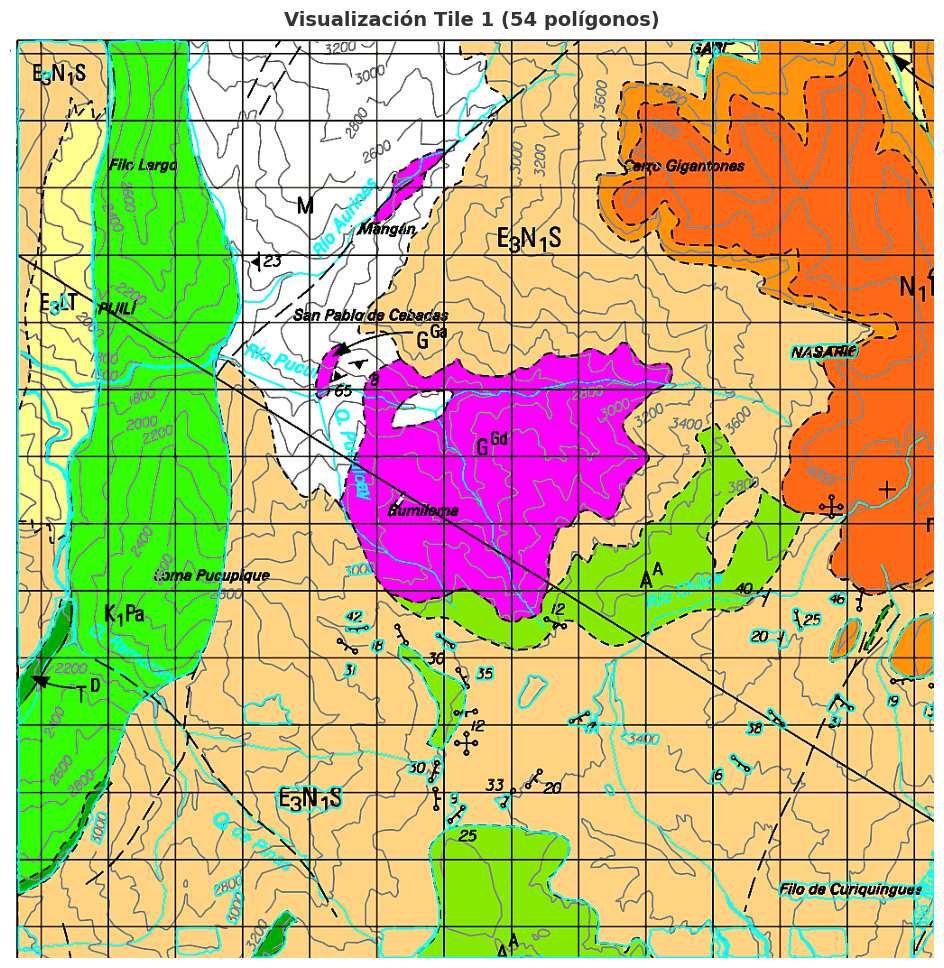

,source,geometry
0,sam,"POLYGON ((57.00000 290.00000, 57.00000 291.000..."
1,sam,"POLYGON ((36.00000 41.00000, 35.00000 42.00000..."
2,sam,"POLYGON ((128.00000 7.00000, 127.00000 8.00000..."
3,sam,"POLYGON ((386.00000 495.00000, 386.00000 498.0..."
4,sam,"POLYGON ((28.00000 7.00000, 27.00000 8.00000, ..."


In [9]:
# ==========================================\
# BLOQUE 6: VISUALIZACIÓN INTELIGENTE (CARGA O PROCESA)
# ==========================================\
# @title 6. Carga de Tile Guardado (con Fallback a Inferencia)

def smart_load_tile_1(image_source, model, output_dir, tile_idx=0):
    """
    Intenta cargar el GeoJSON guardado. Si no existe, ejecuta SAM 2.
    """
    if image_source is None:
        print("❌ Error: No hay imagen cargada.")
        return None, None
        
    tile_size = 1024
    # Cortar imagen visualmente para mostrarla de fondo
    full_img = np.array(image_source)
    img_tile = full_img[0:tile_size, 0:tile_size]
    
    # RUTA DEL ARCHIVO GUARDADO (Tile 1 de la UI es índice 0)
    file_name = f"tile_{tile_idx}.geojson"
    file_path = os.path.join(output_dir, file_name)
    
    # --- OPCIÓN A: CARGAR DESDE DISCO (Rápido) ---
    if os.path.exists(file_path):
        print(f"📂 Archivo detectado: {file_name}")
        print("⚡ Cargando polígonos guardados (Saltando inferencia)...")
        try:
            gdf = gpd.read_file(file_path)
            print(f"✅ Carga exitosa: {len(gdf)} polígonos recuperados.")
            return gdf, img_tile
        except Exception as e:
            print(f"⚠️ Error leyendo archivo: {e}. Pasando a modo cálculo...")

    # --- OPCIÓN B: CALCULAR DESDE CERO (Respaldo) ---
    print(f"🔄 Calculando Tile {tile_idx + 1} con SAM 2...")
    
    # Generador
    mask_generator = SAM2AutomaticMaskGenerator(
        model=model,
        points_per_side=64,
        pred_iou_thresh=0.75,
        stability_score_thresh=0.85,
        min_mask_region_area=500
    )
    
    masks = mask_generator.generate(img_tile)
    
    # Funciones de limpieza internas para no depender de bloques anteriores
    def quick_clean(masks_list):
        solid = []
        for m in masks_list:
            # Fix memoria OpenCV
            seg = np.ascontiguousarray(m['segmentation'].astype(np.uint8))
            cnts, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            new_mask = np.zeros(seg.shape, dtype=np.uint8)
            cv2.drawContours(new_mask, cnts, -1, 1, thickness=cv2.FILLED)
            
            # Solo guardamos lo necesario para convertir a poligono
            m_copy = m.copy()
            m_copy['segmentation'] = new_mask.astype(bool)
            solid.append(m_copy)
        return solid

    masks = quick_clean(masks)
    
    geoms = []
    for m in masks:
        cnts, _ = cv2.findContours(m['segmentation'].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in cnts:
            if len(c) > 2:
                poly = Polygon(c.squeeze().reshape(-1, 2))
                if poly.is_valid and poly.area > 50:
                    geoms.append(poly)
                    
    gdf = gpd.GeoDataFrame({'geometry': geoms, 'id': range(len(geoms))})
    print(f"✅ Cálculo completado: {len(gdf)} polígonos generados.")
    return gdf, img_tile

# --- EJECUCIÓN ---
# Nota: Tile 1 en la UI corresponde al índice 0 internamente
gdf_tile1, img_tile1 = smart_load_tile_1(processed_image_global, sam2_model, OUTPUT_DIR, tile_idx=0)

# --- VISUALIZACIÓN ---
if gdf_tile1 is not None:
    plt.figure(figsize=(12, 12))
    plt.imshow(img_tile1)
    
    # Plotear polígonos (Cian brillante)
    # CORRECCIÓN: aspect=1 evita el error 'aspect must be finite' forzando proporción de píxeles 1:1
    gdf_tile1.plot(ax=plt.gca(), facecolor='none', edgecolor='cyan', linewidth=1.5, alpha=0.9, aspect=1)
    
    plt.title(f"Visualización Tile 1 ({len(gdf_tile1)} polígonos)", fontsize=14, fontweight='bold', color='#333')
    plt.axis('off')
    plt.show()
    
    display(gdf_tile1.head())

# Bloque 7

In [16]:
# ==========================================\
# BLOQUE 7: CONFIGURACIÓN GEMINI (SOLO API KEY)
# ==========================================\
# @title 7. Configuración de IA (Gemini)
import google.generativeai as genai
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import cv2
import requests
from PIL import Image as PILImage
import io
import json
import matplotlib.pyplot as plt

# Widget simple para la API Key
w_gemini_key = widgets.Password(description="Gemini API Key:", style={'description_width': 'initial'}, layout=widgets.Layout(width='50%'))
btn_auth = widgets.Button(description="🔐 Activar Gemini", button_style='success')
out_auth = widgets.Output()

gemini_configured = False

def autenticar(b):
    global gemini_configured
    with out_auth:
        clear_output()
        if w_gemini_key.value:
            try:
                genai.configure(api_key=w_gemini_key.value)
                # Test rápido de conexión
                m = genai.GenerativeModel('gemini-3-flash-preview')
                _ = m.generate_content("Hola")
                gemini_configured = True
                print("✅ Gemini API conectada y lista.")
            except Exception as e:
                print(f"❌ Error de API Key: {e}")
        else:
            print("⚠️ Por favor ingresa tu API Key.")

btn_auth.on_click(autenticar)
display(widgets.VBox([widgets.HTML("<b>🤖 Configuración del Cerebro (Gemini)</b>"), w_gemini_key, btn_auth, out_auth]))

# Bloque 8

In [12]:
# ==========================================\
# BLOQUE 8: ANÁLISIS DE LEYENDA (GEMINI VISION)
# ==========================================\
# @title 8. Digitalización de la Leyenda Geológica
import pandas as pd
import requests

# URL RAW directa (convertida desde tu blob link)
LEGEND_URL = "https://raw.githubusercontent.com/DalemberV/Geodigit/main/Digitalizacion_Automatica/Mapas%20geol%C3%B3gicos/leyenda_giron.png"

def analyze_legend(url):
    print(f"📥 Descargando leyenda: {url}...")
    img_data = requests.get(url).content
    
    # Prompt para Gemini Vision
    prompt = """
    Analiza esta leyenda de mapa geológico. 
    Genera una tabla JSON estricta donde cada entrada represente una unidad litológica.
    Campos requeridos:
    1. 'codigo': El código corto (ej. Tms, Ki, etc.) si es visible.
    2. 'nombre_litologia': El nombre completo de la unidad o roca.
    3. 'descripcion_visual': Breve descripción de la trama (ej. lineas rojas, cruces, puntos).
    4. 'color_hex': El código de color HEX aproximado dominante del recuadro.
    
    Salida solo JSON puro, sin markdown.
    """
    
    try:
        model = genai.GenerativeModel('gemini-3-flash-preview') # Usamos Flash para rapidez y visión
        
        # Crear objeto imagen para Gemini
        from PIL import Image as PILImage
        import io
        img_pil = PILImage.open(io.BytesIO(img_data))
        
        print("🧠 Gemini analizando leyenda...")
        response = model.generate_content([prompt, img_pil])
        
        # Limpieza de respuesta (quitar ```json si existe)
        txt = response.text.replace("```json", "").replace("```", "").strip()
        data = json.loads(txt)
        
        df = pd.DataFrame(data)
        return df
        
    except Exception as e:
        print(f"❌ Error analizando leyenda: {e}")
        return pd.DataFrame()

# Ejecución
df_legend = analyze_legend(LEGEND_URL)
if not df_legend.empty:
    print("✅ Leyenda Digitalizada:")
    display(df_legend)
else:
    print("⚠️ No se pudo extraer la leyenda.")

📥 Descargando leyenda: https://raw.githubusercontent.com/DalemberV/Geodigit/main/Digitalizacion_Automatica/Mapas%20geol%C3%B3gicos/leyenda_giron.png...
🧠 Gemini analizando leyenda...
✅ Leyenda Digitalizada:


,codigo,nombre_litologia,descripcion_visual,color_hex
0,QA,Depósito aluvial,Fondo amarillo sólido,#FFFF00
1,QT,Terraza,Fondo amarillo muy pálido sólido,#FFFFE0
2,QC,Depósito coluvial,Fondo amarillo pálido sólido,#FFF9C4
3,n5n6Tq,Formación Tarqui,Fondo naranja claro sólido,#FF9E67
4,n1Qs,Formación Quimsacocha,Fondo naranja sólido,#FF8040
5,n5n6Tt,Formación Turi,Fondo naranja amarillento sólido,#FFB366
6,n1Tp,Formación Turupamba,Fondo naranja intenso sólido,#FF6600
7,n5n6Uy,Formación Uchucay,Fondo naranja tierra sólido,#E67E22
8,n1n2Sl,Formación Santa Isabel,Fondo amarillo ocre sólido,#FFE680
9,n3n4N,Formación Nabón,Fondo naranja zanahoria sólido,#FF9933


# Bloque 9

In [18]:
# ==========================================\
# BLOQUE 9: EXTRACCIÓN SOLO RGB (Rápido)
# ==========================================\
# @title 9. Extracción de Color Promedio por Polígono

def extract_color_features(gdf, source_img):
    """
    Extrae el color promedio RGB de cada polígono usando la imagen original.
    """
    if gdf is None or source_img is None:
        return print("❌ Faltan datos (gdf_tile1 o img_tile1).")
    
    # --- CORRECCIÓN ERROR KEYERROR 'id' ---
    # Si el GeoJSON guardado no tenía IDs, los creamos al vuelo.
    if 'id' not in gdf.columns:
        print("⚠️ Columna 'id' no encontrada. Generando IDs automáticos...")
        gdf['id'] = range(len(gdf))
        
    print(f"🎨 Extrayendo color de {len(gdf)} polígonos...")
    
    rgb_results = []
    img_arr = np.array(source_img) # Aseguramos formato numpy
    
    for idx, row in gdf.iterrows():
        poly = row.geometry
        
        # 1. Obtener Bounding Box para no procesar toda la imagen gigante
        minx, miny, maxx, maxy = map(int, poly.bounds)
        
        # 2. Recortar la imagen original (ROI)
        # Esto responde a tu pregunta: SÍ, extraemos de la imagen general
        roi = img_arr[miny:maxy, minx:maxx]
        
        # 3. Crear máscara local (binaria) del mismo tamaño que el ROI
        # Trasladamos las coordenadas del polígono al origen (0,0) del recorte
        crop_w, crop_h = maxx - minx, maxy - miny
        mask_crop = np.zeros((crop_h, crop_w), dtype=np.uint8)
        
        local_poly = [(x - minx, y - miny) for x, y in poly.exterior.coords]
        pts = np.array(local_poly, np.int32)
        
        # Rellenamos el polígono en la máscara
        cv2.fillPoly(mask_crop, [pts], 255)
        
        # 4. Calcular la media de color SOLO donde la máscara es blanca
        if roi.shape[0] > 0 and roi.shape[1] > 0:
            # cv2.mean devuelve (B, G, R, A) o (R, G, B, A) dependiendo del input
            # Asumimos que img_arr es RGB (porque lo cargamos con PIL o convertimos antes)
            avg_color = cv2.mean(roi, mask=mask_crop)[:3]
            rgb_results.append([int(c) for c in avg_color])
        else:
            rgb_results.append([0, 0, 0]) # Fallback negro

    gdf['avg_rgb'] = rgb_results
    print("✅ Colores extraídos.")
    return gdf

# Ejecutar sobre el tile 1
# Asumiendo variables globales del Bloque 6
if 'gdf_tile1' in globals() and gdf_tile1 is not None:
    gdf_processed = extract_color_features(gdf_tile1, img_tile1)
    display(gdf_processed[['id', 'geometry', 'avg_rgb']].head())
else:
    print("⚠️ Ejecuta primero el Bloque 6 para tener los polígonos.")

⚠️ Columna 'id' no encontrada. Generando IDs automáticos...
🎨 Extrayendo color de 54 polígonos...
✅ Colores extraídos.


,id,geometry,avg_rgb
0,0,"POLYGON ((57.00000 290.00000, 57.00000 291.000...","[115, 110, 79]"
1,1,"POLYGON ((36.00000 41.00000, 35.00000 42.00000...","[142, 119, 77]"
2,2,"POLYGON ((128.00000 7.00000, 127.00000 8.00000...","[55, 220, 22]"
3,3,"POLYGON ((386.00000 495.00000, 386.00000 498.0...","[86, 159, 254]"
4,4,"POLYGON ((28.00000 7.00000, 27.00000 8.00000, ...","[216, 205, 127]"


# Bloque 10

🧠 Gemini emparejando colores (RGB Polígonos vs HEX Leyenda)...
✅ Mapa Clasificado.


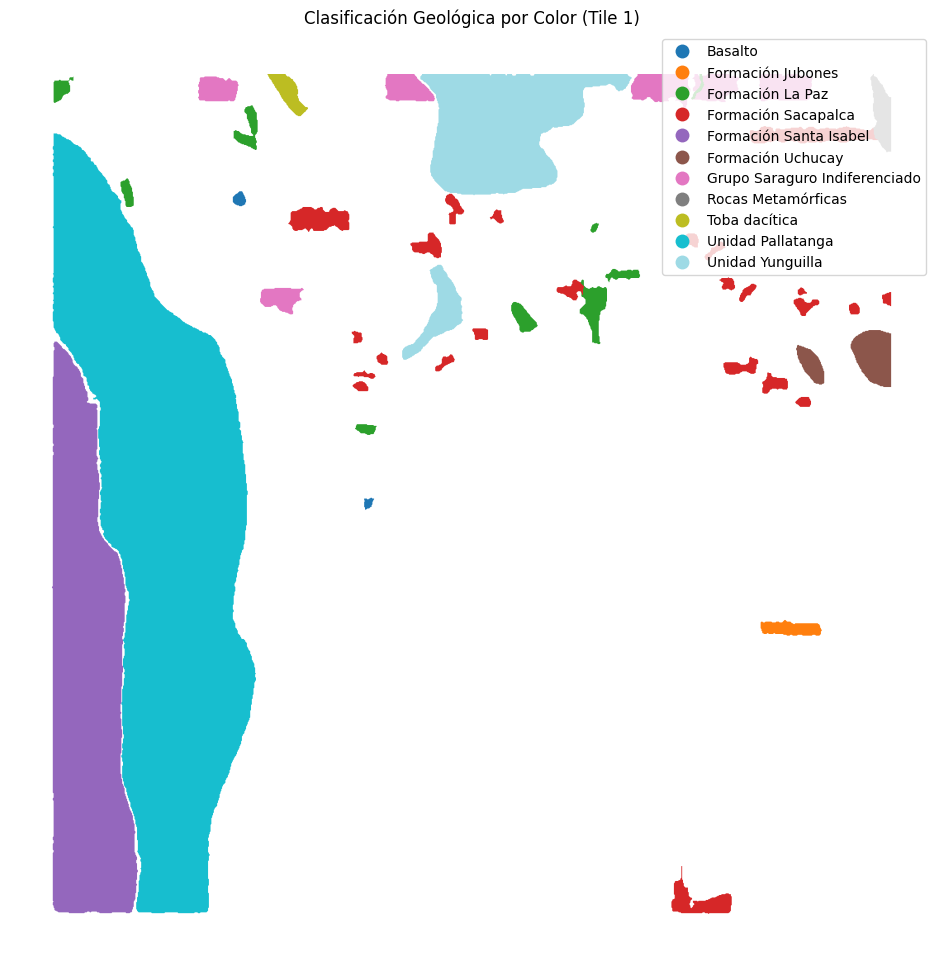

,id,avg_rgb,litologia_match,confianza
0,0,"[115, 110, 79]",Formación Sacapalca,Media
1,1,"[142, 119, 77]",Formación Sacapalca,Alta
2,2,"[55, 220, 22]",Unidad Pallatanga,Alta
3,3,"[86, 159, 254]",Basalto,Baja
4,4,"[216, 205, 127]",Formación Santa Isabel,Alta
5,5,"[125, 207, 12]",Unidad Yunguilla,Alta
6,6,"[117, 184, 16]",Unidad Yunguilla,Media
7,7,"[221, 133, 20]",Formación Uchucay,Alta
8,8,"[147, 129, 86]",Formación Sacapalca,Alta
9,9,"[250, 209, 129]",Grupo Saraguro Indiferenciado,Alta


In [21]:
# ==========================================\
# BLOQUE 10: MATCHING POR COLOR (GEMINI)
# ==========================================\
# @title 10. Reconciliación Colorimétrica con IA

def ai_color_matching(gdf_poly, df_legend):
    if not gemini_configured: return print("❌ Configura Gemini.")
    
    print("🧠 Gemini emparejando colores (RGB Polígonos vs HEX Leyenda)...")
    
    # --- CORRECCIÓN DE COLUMNAS (Robustez) ---
    cols_to_use = ['codigo', 'nombre_litologia', 'color_hex']
    if 'descripcion_color' in df_legend.columns:
        cols_to_use.append('descripcion_color')
    elif 'descripcion_visual' in df_legend.columns:
        cols_to_use.append('descripcion_visual')
    
    # Preparamos los datos
    legend_str = df_legend[cols_to_use].to_csv(index=False)
    poly_str = gdf_poly[['id', 'avg_rgb']].to_csv(index=False)
    
    prompt = f"""
    Eres un experto en colorimetría geológica.
    Tu tarea es asignar la unidad de la leyenda correcta a cada polígono basándote EXCLUSIVAMENTE en la similitud de color.

    --- TABLA LEYENDA (Estándar) ---
    {legend_str}

    --- TABLA POLÍGONOS DETECTADOS (Muestras de Campo) ---
    {poly_str}

    --- INSTRUCCIONES ---
    1. Para cada polígono, compara su valor 'avg_rgb' con los 'color_hex' y la descripción de color de la leyenda.
    2. Ten en cuenta que el color extraído puede tener ligeras variaciones de iluminación o ruido. Busca la coincidencia perceptiva más cercana.
    3. Si un RGB es muy oscuro o grisáceo y no coincide con nada, revisa si la leyenda tiene tramas descritas como "líneas negras", etc.
    4. Devuelve un JSON con esta estructura:
       [
         {{"id": 0, "litologia_match": "Nombre de la Leyenda", "confianza": "Alta/Media/Baja"}},
         ...
       ]
    """
    
    try:
        model = genai.GenerativeModel('gemini-3-flash-preview')
        response = model.generate_content(prompt)
        
        txt = response.text.replace("```json", "").replace("```", "").strip()
        matches = json.loads(txt)
        df_matches = pd.DataFrame(matches)
        
        # Unir resultados
        gdf_final = gdf_poly.merge(df_matches, on='id', how='left')
        return gdf_final
        
    except Exception as e:
        print(f"❌ Error en matching: {e}")
        return gdf_poly

# Ejecución
if 'gdf_processed' in globals() and 'df_legend' in globals():
    gdf_final = ai_color_matching(gdf_processed, df_legend)
    
    if 'litologia_match' in gdf_final.columns:
        print("✅ Mapa Clasificado.")
        
        # Visualización Final
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        
        # --- CORRECCIÓN FINAL: aspect=1 para evitar error de proyección ---
        gdf_final.plot(column='litologia_match', ax=ax, legend=True, cmap='tab20', legend_kwds={'bbox_to_anchor': (1, 1)}, aspect=1)
        
        ax.set_title("Clasificación Geológica por Color (Tile 1)")
        ax.axis('off')
        plt.show()
        
        display(gdf_final[['id', 'avg_rgb', 'litologia_match', 'confianza']].head(10))
    else:
        print("⚠️ La IA no devolvió coincidencias.")
else:
    print("⚠️ Faltan datos anteriores.")

ℹ️ Usando datos clasificados del Bloque 10.
📊 Generando comparativa para 54 polígonos...


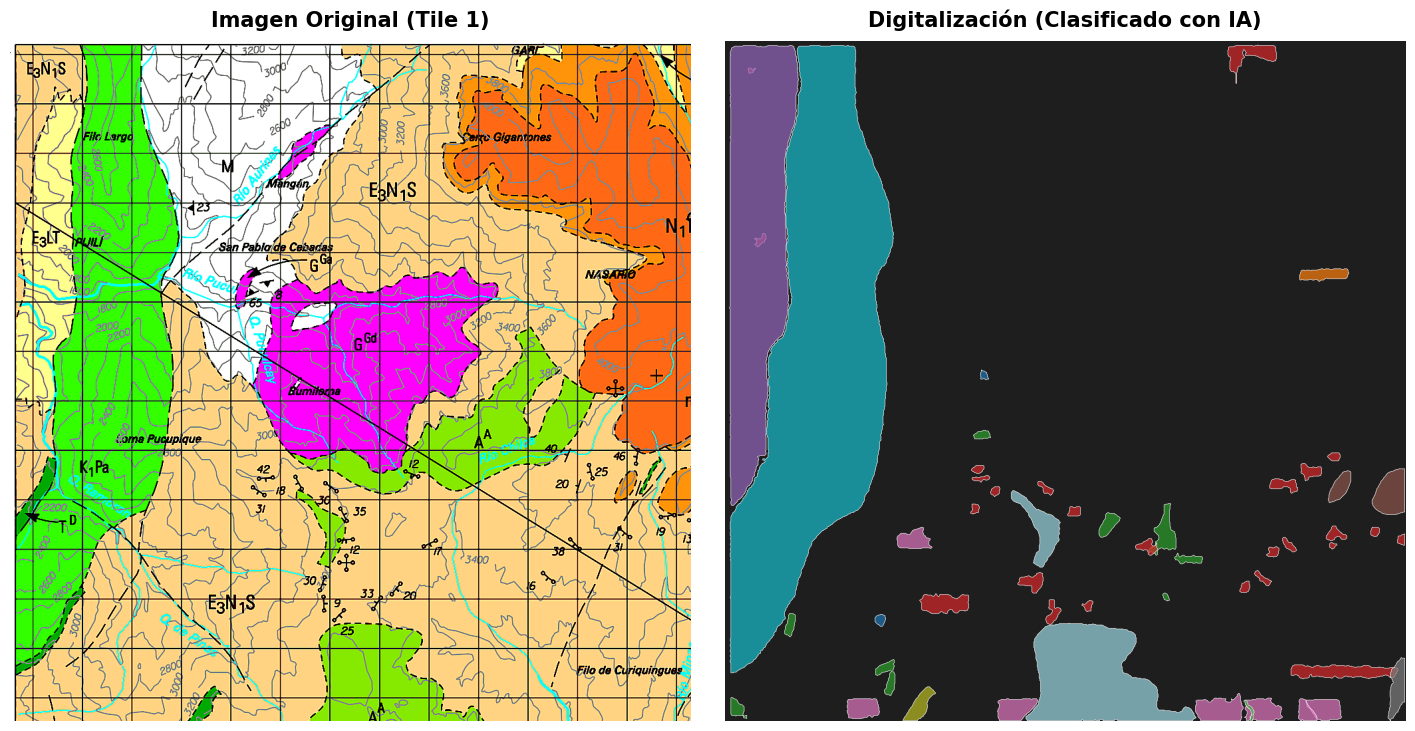

In [22]:
# ==========================================\
# BLOQUE 11: VISUALIZACIÓN SIDE-BY-SIDE (ORIGINAL VS VECTORES)
# ==========================================\
# @title 11. Comparativa: Imagen Original vs. Vectores (Bloque 6)

def plot_side_by_side_check():
    """
    Muestra la imagen original a la izquierda y los polígonos extraídos a la derecha.
    Intenta usar los polígonos clasificados (gdf_final) si existen, si no usa los crudos (gdf_tile1).
    """
    
    # 1. Determinar qué datos usar
    data_to_plot = None
    title_suffix = ""
    
    if 'gdf_final' in globals() and gdf_final is not None:
        data_to_plot = gdf_final
        title_suffix = "(Clasificado con IA)"
        print("ℹ️ Usando datos clasificados del Bloque 10.")
    elif 'gdf_tile1' in globals() and gdf_tile1 is not None:
        data_to_plot = gdf_tile1
        title_suffix = "(Solo Geometría)"
        print("ℹ️ Usando geometría cruda del Bloque 6.")
    else:
        print("❌ Error: No se encontraron datos. Ejecuta Bloque 6 (y opcionalmente 10).")
        return

    if 'img_tile1' not in globals() or img_tile1 is None:
        print("❌ Error: No se encuentra la imagen del Tile 1.")
        return

    print(f"📊 Generando comparativa para {len(data_to_plot)} polígonos...")

    # 2. Configurar Plot
    fig, axes = plt.subplots(1, 2, figsize=(18, 9), gridspec_kw={'wspace': 0.05})
    
    # --- PANEL IZQUIERDO: IMAGEN ORIGINAL ---
    axes[0].imshow(img_tile1)
    axes[0].set_title("Imagen Original (Tile 1)", fontsize=15, fontweight='bold', pad=10)
    axes[0].axis('off')
    
    # --- PANEL DERECHO: VECTORES (GEOJSON) ---
    # Fondo oscuro simulando CAD
    bg = np.zeros_like(img_tile1) + 30 # Gris muy oscuro (RGB 30,30,30)
    axes[1].imshow(bg)
    
    # Lógica de colores
    if 'litologia_match' in data_to_plot.columns:
        # Si hay clasificación, colorear por unidad geológica
        data_to_plot.plot(
            column='litologia_match', 
            ax=axes[1], 
            cmap='tab20', 
            alpha=0.7, 
            edgecolor='white', 
            linewidth=0.5,
            aspect=1 # <--- VITAL
        )
        # Añadir leyenda si hay clases
        # (Truco para leyenda fuera del plot)
        # leg = axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # Si es solo geometría, contornos cian neón
        data_to_plot.plot(
            ax=axes[1], 
            facecolor='none', 
            edgecolor='#00FFCC', # Cian Neón
            linewidth=1.5, 
            alpha=0.9,
            aspect=1 # <--- VITAL
        )
    
    axes[1].set_title(f"Digitalización {title_suffix}", fontsize=15, fontweight='bold', pad=10)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ejecutar visualización
plot_side_by_side_check()